# Testing pyciemss-based workflow



# Demo

network model --> probablistic model --> model analysis

In [16]:
# Load the autoreload extension
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import nocap.utility as utility
import mira
import pyciemss
import networkx as nx
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model
from pathlib import Path
import matplotlib.pyplot as plt
import tellurium as te
from mira.sources.sbml import template_model_from_sbml_file
import pyciemss.visuals.plots as plots
from mira.modeling.ode import OdeModel
from mira.modeling.viz import GraphicalModel
from mira.modeling import Model
from mira.metamodel import Distribution

import numpy as np
import pandas as pd
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# from network to SBML model

### Toy network

A --> B; A activates B

C --| B; C represses B

B --> D; B activates D


\
*modeling notes:*
- currently demonstrating transient (non-steady state) behavior, but steady-state can be calculated
- using Hill equations for the reaction rate of species Y from regulator species X:
  - activation: $ \frac{\beta}{1 + \frac{K^n}{X^n}}$
  - repression: $ \frac{\beta}{1 + \frac{X^n}{K^n}} $
  - assumes (for now) reaction rates from parents are a linear combination - e.g. $v_B = v_{AB} + v_{CB}$
- approach: 
  - add graph nodes as species 
  - go through each network edge and add the reaction w/ kinetic law based on the edge type
  - use antimony for human readable model that gets converted into SBML

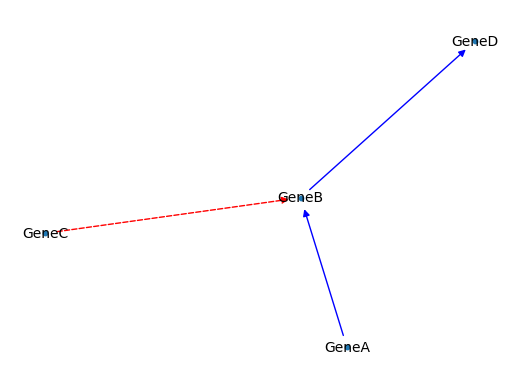

In [17]:
# create toy network
abcd_dag = nx.DiGraph()
abcd_dag.add_node('GeneA', value=10.0)  
abcd_dag.add_node('GeneB', value=0.0)
abcd_dag.add_node('GeneC', value=10.0)  
abcd_dag.add_node('GeneD', value=0.0)
abcd_dag.add_edge('GeneA', 'GeneB', interaction_type='activation')
abcd_dag.add_edge('GeneC', 'GeneB', interaction_type='repression')
abcd_dag.add_edge('GeneB', 'GeneD', interaction_type='activation')


# plot graph
# plot the network
G = abcd_dag
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=10)
activation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'activation']
repression_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'repression']
nx.draw_networkx_edges(G, pos, edgelist=activation_edges, edge_color='blue', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=repression_edges, edge_color='red', arrows=True, style='dashed')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()



In [18]:
# set parameters for Hill equation
hill_parameters = {
    'beta_GeneA_to_GeneB': 1,
    'K_GeneA_to_GeneB': 1,
    'n_GeneA_to_GeneB': 1,
    'beta_GeneC_to_GeneB': 1,
    'K_GeneC_to_GeneB': 1,
    'n_GeneC_to_GeneB': 1,
    'beta_GeneB_to_GeneD': 1,
    'K_GeneB_to_GeneD': 1,
    'n_GeneB_to_GeneD': 1
}

dist_params = {}  # use default Uniform distributions for state variables and parameters

# Create SBML file
model_name = "ABCD_model"
sbml_filename = model_name + ".xml"
utility.create_sbml_model_from_nx(G, 
                                  sbml_filename, 
                                  hill_params=hill_parameters,
                                  dist_params=dist_params)  # networkx to SBML


print(te.getODEsFromSBMLFile(sbml_filename))



SBML model written to ABCD_model.xml

vJ_GeneA_to_GeneB = 1*pow(GeneA,n_GeneA_to_GeneB)/(pow(K_GeneA_to_GeneB,n_GeneA_to_GeneB)+pow(GeneA,n_GeneA_to_GeneB))
vJ_GeneB_to_GeneD = 1*pow(GeneB,n_GeneB_to_GeneD)/(pow(K_GeneB_to_GeneD,n_GeneB_to_GeneD)+pow(GeneB,n_GeneB_to_GeneD))
vJ_GeneC_to_GeneB = 1/(1+pow(GeneC,n_GeneC_to_GeneB)/1)

dGeneA/dt = -vJ_GeneA_to_GeneB
dGeneB/dt = vJ_GeneA_to_GeneB - vJ_GeneB_to_GeneD + vJ_GeneC_to_GeneB
dGeneC/dt = -vJ_GeneC_to_GeneB
dGeneD/dt = vJ_GeneB_to_GeneD



### model simulation using tellurium and libroadrunner

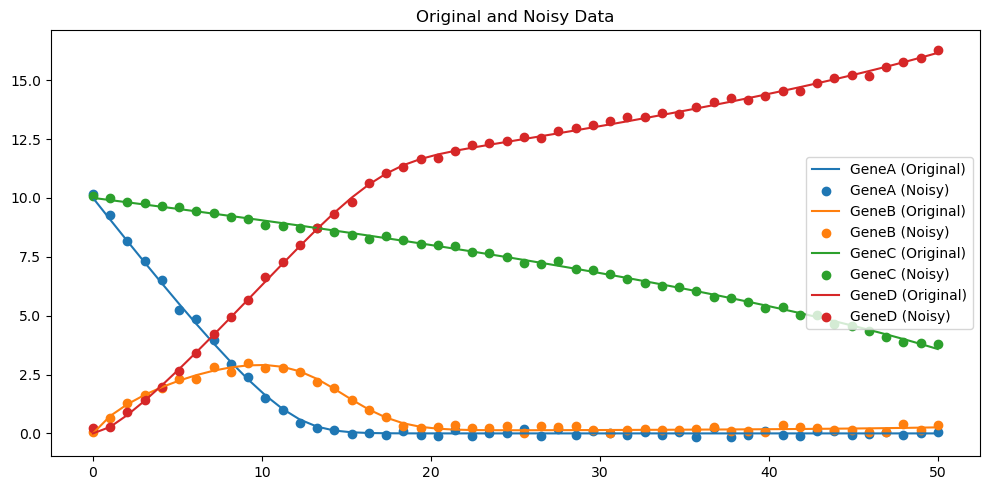

In [6]:
# Load and simulate the model
rr_model = te.loadSBMLModel(sbml_filename)
rr_results = rr_model.simulate(0, 50, 50, selections=['time', '[GeneA]', '[GeneB]', '[GeneC]', '[GeneD]'])


# format, add noise 
rr_results_df = pd.DataFrame(rr_results, columns=rr_results.colnames)
rr_results_df = rr_results_df.set_index('time')
rr_results_df.index.names = ['Timestamp']  # must be 'Timestamp' for pyciemss
rr_results_df.columns = rr_results_df.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)

seed = 0
np.random.seed(seed)
rr_results_df_noisy = rr_results_df.copy()
noise = np.random.normal(0, 0.1, rr_results_df.shape)
rr_results_df_noisy += noise


# plot
fig, ax = plt.subplots(figsize=(10, 5))
for column in rr_results_df.columns:
    ax.plot(rr_results_df.index, rr_results_df[column], label=f'{column} (Original)', linestyle='-')
    ax.scatter(rr_results_df_noisy.index, rr_results_df_noisy[column], label=f'{column} (Noisy)', marker='o')

ax.set_title('Original and Noisy Data')
ax.legend()
plt.tight_layout()
plt.show() 

# save data
rr_data_filepath = model_name + "_data.csv"
rr_data_filepath_noisy = model_name + "_noisy_data.csv"
rr_results_df.to_csv(rr_data_filepath)
rr_results_df_noisy.to_csv(rr_data_filepath_noisy)

### stochastic simulation using Tellurium/Libroadrunner

 todo: negative concentration in SDE?

In [ ]:
# use a stochastic solver
rr_model.integrator = 'gillespie'
# selections specifies the output variables in a simulation
selections = ['time', '[GeneA]', '[GeneB]', '[GeneC]', '[GeneD]']
rr_model.integrator.variable_step_size = False

# run repeated simulation
Ncol = len(selections)
Nsim = 100
points = 100
t_start = 0
t_end = 50
s_sum = np.zeros(shape=[points, Ncol])
for k in range(Nsim):
    rr_model.resetToOrigin()
    s = rr_model.simulate(t_start, t_end, points, selections=selections)
    s_sum += s
    rr_model.plot(s, alpha=0.25, show=False)

# # add mean curve, legend, show everything and set labels, titels, ...
t = s[:,0]
y_mean = s_sum[:,1:]/Nsim
fig = te.plot(t, y_mean, names=[x + ' (mean)' for x in selections[1:]], title="Stochastic simulation", xlabel="time", ylabel="concentration")


In [ ]:
colors = ['blue', 'green', 'red', 'purple']
fig, ax = plt.subplots(figsize=(10, 5))
for i, column in enumerate(rr_results_df.columns):
    ax.plot(rr_results_df.index, rr_results_df[column], label=f'{column} (ODE)', linestyle='-', color=colors[i])
    ax.scatter(rr_results_df_noisy.index, rr_results_df_noisy[column], label=f'{column} (ODE + Noise)', marker='o', alpha=0.25,color=colors[i])
    ax.plot(t, y_mean[:,i], label= f'{selections[1+i]} (SDE mean)', ls='--', color=colors[i])
ax.set_title('Synthetic time series - ODE, ODE + Gaussian noise, SDE average')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('y')
plt.tight_layout()
plt.show() 

# create a causal probablistic model

This type of model is well-suited to Bayesian/Causal inference, performing interventions/pertubations on data

procedure:
- convert SBML into a 'template (meta) model' using MIRA
- assign priors on the model parameters (this could be done from SBML)
- save as a petri net model to use in pyciemss (probablistic causal inference for dynamic systems models)

In [ ]:
mira_model = template_model_from_sbml_file(sbml_filename)

# assign priors for the model parameters
for name,parameter in mira_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = Distribution(type="Uniform1", parameters={"minimum": 0.99, "maximum": 1.11})

# display(mira_model.parameters)
# display(mira_model.initials)

petrinet_model_filename = model_name + '_petrinet_w_priors.json'
file_root = Path(petrinet_model_filename).stem
petrinet_model = AMRPetriNetModel(Model(mira_model))
petrinet_model.to_json_file(
                petrinet_model_filename,
                name=file_root,
                description=file_root,
                indent=2,
            )

om = OdeModel(Model(mira_model), initialized=False)
display(om.get_interpretable_kinetics())
display(GraphicalModel.for_jupyter(mira_model))


# simulating a model in pyciemss - parameter sensitivity

Sampling from the prior distributions for the Hill equation parameters, we see a large variance in outcomes for different parameter values 

In [ ]:
start_time = 0.0
end_time = 50
logging_step_size = 1
num_samples = 100


petrinet_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, start_time=start_time, 
                                   solver_method='euler', solver_options={'step_size':0.00001})


# Plot results for all states
schema = plots.trajectories(petrinet_results["data"], keep=".*_state", points=rr_results_df_noisy.reset_index(drop=True))
plots.ipy_display(schema, dpi=150)



# calibrating the model to data

Fit the parameters of the Hill equations to the noisy simulated data

In [ ]:
data_filepath = rr_data_filepath_noisy
num_iterations = 100
model_path_or_json = petrinet_model_filename
data_mapping = {k:k for k in rr_results_df_noisy.columns}  
start_time = 0.0

# calibration_results = pyciemss.calibrate(model_path_or_json, data_filepath, data_mapping=data_mapping, 
#                                          num_iterations=num_iterations, verbose=False, 
#                                          start_time=start_time, 
#                                          solver_method='euler', solver_options={'step_size':logging_step_size/2})


calibration_results = pyciemss.calibrate(model_path_or_json, data_filepath, data_mapping=data_mapping, 
                                            num_iterations=num_iterations, verbose=False, 
                                            start_time=start_time,
                                            solver_method='scipy_solver', 
                                            solver_options={'solver':'LSODA'})

In [ ]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 50
logging_step_size = 0.5
num_samples = 100

parameter_estimates = calibration_results["inferred_parameters"]

calibrated_sample_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates,solver_method='scipy_solver', 
                                            solver_options={'solver':'LSODA'})

schema = plots.trajectories(calibrated_sample_results["data"], keep=".*_state",points=rr_results_df_noisy.reset_index(drop=True))
plots.ipy_display(schema, dpi=150)


# interventions

At t=25 we intervene and set GeneA back to 10, which results in a ~50% increase in the amount of GeneD vs no intervention

In [ ]:
intervened_calibrated_sample_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, 
                                                       num_samples, start_time=start_time, 
                                                       inferred_parameters=parameter_estimates,
                                                       solver_options={'solver':'LSODA'},                                        
                            static_state_interventions={torch.tensor(25.0): {'GeneA':torch.tensor(10.0)}})

schema = plots.trajectories(intervened_calibrated_sample_results["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

# dynamic interventions

when GeneD > 5, set GeneB to 0

In [ ]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold  
    return var_threshold
    
threshold = make_var_threshold("GeneD", torch.tensor(5.0))
dynamic_state_interventions1 = {threshold: {"GeneB": torch.tensor(0.0)}} 



dynamic_intervened_calibrated_sample_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates, solver_method='euler', solver_options={'step_size':logging_step_size/2}, 
                dynamic_state_interventions=dynamic_state_interventions1)

schema = plots.trajectories(dynamic_intervened_calibrated_sample_results["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

# optimization

find an intervention policy (adjust $K_{\mathrm{GeneAtoGeneB}}$ at t=2) that ensures that geneB expression stays below 1.


$$
\begin{array}{ll}
\text{Minimize:} & | K_{\text{current}} - x | \quad \text{where} \; K_{\text{current}} = 2 \\\\

\text{Subject to:} & \max_{t} (\text{GeneB}_{\text{state}}(t)) \leq 1.0 \quad \text{for} \; t \in [0, 50] \\\\
                   & 1 \leq x \leq 100 \\\\
                   & K_{\text{GeneA\_to\_GeneB}}(t=2) = x \\\\

\end{array}
$$


In [ ]:
from tqdm import tqdm
from typing import Dict, List
from pyciemss.integration_utils.intervention_builder import param_value_objective, start_time_objective


start_time = 0.0
end_time = 50
logging_step_size = 0.5
num_samples = 100

observed_params = ["GeneB_state"]
intervened_params = ["K_GeneA_to_GeneB"]

maxiter=10
maxfeval=100

def obs_max_qoi(samples: Dict[str, torch.Tensor], contexts: List) -> np.ndarray:    
    """Return maximum value over simulated time.    
    samples is is the output from a Pyro Predictive object.    
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)    
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.max(dataQoI, axis=1)

K_GeneA_to_GeneB_current = 2
initial_guess_interventions = 5
bounds_interventions = [[1], [100]]
intervention_time = [torch.tensor(2.0)]

risk_bound = 1.0  # this is for geneB state (find K such that geneB doesn't go over this)
qoi = lambda x: obs_max_qoi(x, observed_params)
objfun = lambda x: np.abs(K_GeneA_to_GeneB_current - x)  # function to be optimized - find minimize difference between current K and proposed K value subject to constraint

static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    param_value=[lambda x: torch.tensor(x)],
    start_time=intervention_time,
)

# Progress bar
pbar = tqdm(total=maxfeval * (maxiter + 1))

# update_progress(coordinate, function_min, accept)
def update_progress(xk):
    pbar.update(1)

opt_result = pyciemss.optimize(
    petrinet_model_filename,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=int(1e2),
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="euler",
    solver_options={"step_size": 0.1},
)
print(f"Optimal policy:", opt_result["policy"])
print(opt_result)


In [ ]:
result = pyciemss.sample(
    petrinet_model_filename,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
    solver_options={"step_size": logging_step_size/2},
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
#plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# static model check
check model using tellurium
https://libroadrunner.readthedocs.io/en/latest/stability.html

Jacobian = partial derivative matrix of dV_i/x_i (change in reaction rate of reaction i per change in species concentration i)

essentially this shows how changes in one species concentration affects the rate of change of all other species in the reaction network

if eigenvalue is negative --> system is overdamped and will relax to a steady-state

if eigenvalue is positive --> system will not relax to a steady-state

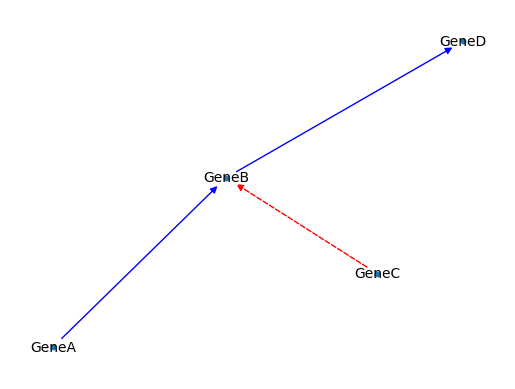

In [145]:
G = abcd_dag
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=10)
activation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'activation']
repression_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'repression']
nx.draw_networkx_edges(G, pos, edgelist=activation_edges, edge_color='blue', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=repression_edges, edge_color='red', arrows=True, style='dashed')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()


In [165]:
from tellurium import ParameterScan 

rr_model2 = te.loadSBMLModel(sbml_filename)

display(rr_model2.getGlobalParameterIds())
print(te.getODEsFromSBMLFile(sbml_filename))

['n_GeneA_to_GeneB',
 'K_GeneA_to_GeneB',
 'beta_GeneA_to_GeneB',
 'n_GeneB_to_GeneD',
 'K_GeneB_to_GeneD',
 'beta_GeneB_to_GeneD',
 'n_GeneC_to_GeneB',
 'beta_GeneC_to_GeneB',
 'K_GeneC_to_GeneB']


vJ_GeneA_to_GeneB = 1*pow(GeneA,n_GeneA_to_GeneB)/(pow(K_GeneA_to_GeneB,n_GeneA_to_GeneB)+pow(GeneA,n_GeneA_to_GeneB))
vJ_GeneB_to_GeneD = 1*pow(GeneB,n_GeneB_to_GeneD)/(pow(K_GeneB_to_GeneD,n_GeneB_to_GeneD)+pow(GeneB,n_GeneB_to_GeneD))
vJ_GeneC_to_GeneB = 1/(1+pow(GeneC,n_GeneC_to_GeneB)/1)

dGeneA/dt = -vJ_GeneA_to_GeneB
dGeneB/dt = vJ_GeneA_to_GeneB - vJ_GeneB_to_GeneD + vJ_GeneC_to_GeneB
dGeneC/dt = -vJ_GeneC_to_GeneB
dGeneD/dt = vJ_GeneB_to_GeneD



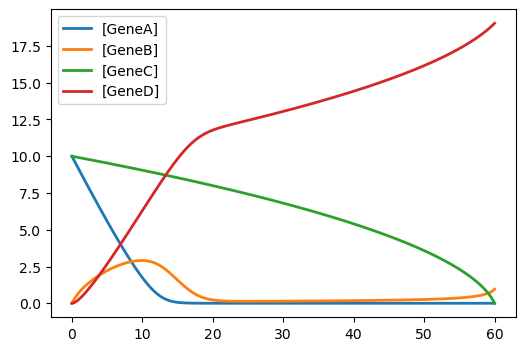

In [188]:

# check solver
rr_model2.simulate(0, 60, 1000, selections=['time', '[GeneA]', '[GeneB]', '[GeneC]', '[GeneD]'])
rr_model2.plot()
rr_model2.resetToOrigin()

In [177]:
jac = rr_model2.getFullJacobian()
jac

             GeneA,       GeneB,        GeneC, GeneD
GeneA [[ -0.999999,           0,            0,     0],
GeneB  [  0.999999, -3.4287e-13, -3.42855e-13,     0],
GeneC  [         0,           0,  3.42855e-13,     0],
GeneD  [         0,  3.4287e-13,            0,     0]]

In [174]:
rr_model2.getReducedJacobian()

               GeneA, GeneB,       GeneC, GeneD
GeneA [[ -0.00826446,     0,           0,     0],
GeneB  [  0.00826446,    -1, -0.00826446,     0],
GeneC  [           0,     0,  0.00826446,     0],
GeneD  [           0,     1,           0,     0]]

In [178]:
import numpy as np
import pandas as pd

# Define the Jacobian matrix:
J = np.array(jac.tolist())
# Compute the eigenvalues:
eigenvalues = np.linalg.eigvals(J)

# Define the labels:
labels = ['GeneA', 'GeneB', 'GeneC', 'GeneD']

# Create a DataFrame to preserve labels:
eigenvalue_df = pd.DataFrame({
    'Gene': labels,
    'Eigenvalue': eigenvalues
})

# Display the results:
display(eigenvalue_df)

,Gene,Eigenvalue
0,GeneA,0.000000e+00
1,GeneB,-3.428696e-13
2,GeneC,-9.999994e-01
3,GeneD,3.428548e-13


GeneD has a positive eigenvalue so it's unstable

Try adjusting a parameter such that it becomes stable

In [155]:
# Define the range for K_GeneB_to_GeneD in logarithmic scale
K_range = np.logspace(-3, 3, num=100)  

def check_stability(jacobian):
    eigenvalues = np.linalg.eigvals(jacobian)
    return all(np.real(eigenvalues) <= 0)

parameter_name = 'K_GeneB_to_GeneD'

# Loop through the K_GeneB_to_GeneD values
for K_value in K_range:
    # Set the new value for K_GeneB_to_GeneD
    rr_model2.setGlobalParameterByName(parameter_name,K_value) 
    jacobian = np.array(rr_model2.getFullJacobian().tolist())
    if check_stability(jacobian):

        rr_model2.simulate(0, 100, 50, selections=['time', '[GeneA]', '[GeneB]', '[GeneC]', '[GeneD]'])
        rr_model2.plot()
        display(f"using stable eigenvalues found using {parameter_name} = {K_value}: {np.real(np.linalg.eigvals(jacobian))}")
        rr_model2.resetToOrigin()
        break

can't find stable solution by perturbing a single K value --> can try adjusting multiple values

## using mass action kinetics

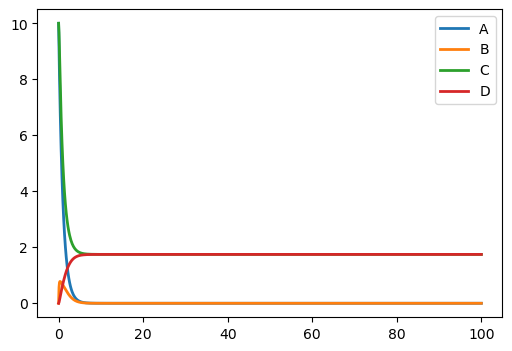

In [143]:
# Define the Antimony model
model = '''
    model mass_action_model
        // Define species
        species A, B, C, D;

        // Define kinetic parameters
        const k_A_to_B = 1.0;
        const k_C_repress_B = 1.0;  // Adjust as needed
        const k_B_to_D = 1.0;

        // Initial conditions
        A = 10;
        B = 0;
        C = 10;
        D = 0;

        // Reactions
        R1: A => B; k_A_to_B * A;
        R2: C + B => ; k_C_repress_B * C * B;  // Repression modeled as degradation of B facilitated by C
        R3: B => D; k_B_to_D * B;
    end
'''

# Load the model
r = te.loadAntimonyModel(model)

# Simulate the system over a long period to observe the behavior
result = r.simulate(0, 100, 1000, ['time', 'A', 'B', 'C', 'D'])
r.plot()

jacobian = np.array(r.getFullJacobian().tolist())
eigenvalues = np.linalg.eigvals(jacobian)



In [144]:
display(np.real(eigenvalues))

array([ 0.00000000e+00, -2.74552460e+00, -1.01161083e-15, -1.00000000e+00])

In [189]:
r.steadyState()

3.849747365670148e-30

In [142]:
# rr_model2.conservedMoietyAnalysis = True
# #rr_model2.steadyState()